In [28]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Data Preprocessing

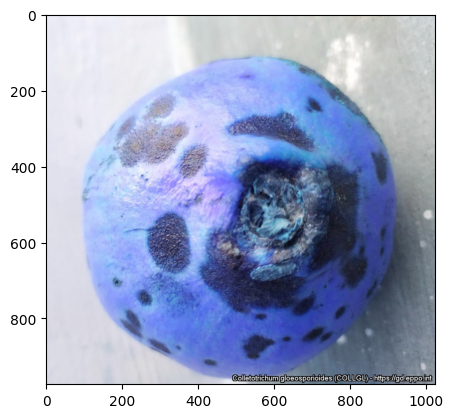

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

Train_DIR = '/Users/shivangisingh/Desktop/pomegranate_disease_detection-main/images/train'
Categories = ['anthracnose', 'healthy', 'heartrot', 'sample']

for category in Categories:
    path = os.path.join(Train_DIR, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        old_image = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
        plt.imshow(old_image)
        plt.show()
        break
    break  # Remove this line if you want to iterate through all categories


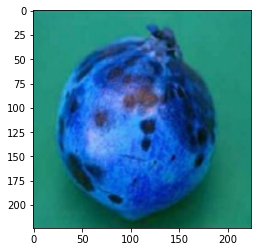

In [15]:
IMG_SIZE=224
new_image=cv2.resize(old_image,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_image)
plt.show()

# Model Prepration

In [16]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D, Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob

In [17]:
IMGE_SIZE = [224, 224]
inception = InceptionV3(input_shape=IMGE_SIZE + [3], weights='imagenet', include_top=False)


In [18]:
# don't train existing weights

for layer in inception.layers:
    layer.trainable = False

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the target size for resizing images
IMG_SIZE = 224  # Example size, adjust according to your model requirements

# Define the new path for training and validation data
Train_DIR = '/Users/shivangisingh/Desktop/pomegranate_disease_detection-main/images/train'

# Define ImageDataGenerator with augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

# Generate training data
train_datagen = datagen.flow_from_directory(
    directory=Train_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

# Generate validation data
val_datagen = datagen.flow_from_directory(
    directory=Train_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)


Found 354 images belonging to 3 classes.
Found 87 images belonging to 3 classes.


In [4]:
from glob import glob

# Define the new path for the folders
folders = glob('/Users/shivangisingh/Desktop/pomegranate_disease_detection-main/images/train/*')

# Print the list of folders found
print(folders)


['/Users/shivangisingh/Desktop/pomegranate_disease_detection-main/images/train/anthracnose', '/Users/shivangisingh/Desktop/pomegranate_disease_detection-main/images/train/healthy', '/Users/shivangisingh/Desktop/pomegranate_disease_detection-main/images/train/heartrot']


In [5]:
x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)
model.summary()

NameError: name 'Flatten' is not defined

In [22]:
# Compile the Model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the new path for saving the model checkpoint
checkpoint_path = '/Users/shivangisingh/Desktop/pomegranate_disease_detection-main/models/pomegranate_inceptionv3.h5'

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Define EarlyStopping callback
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Combine callbacks into a list
callbacks = [checkpoint, earlystop]


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=/Users/shivangisingh/Desktop/pomegranate_disease_detection-main/models/pomegranate_inceptionv3.h5

In [24]:
# fit the model
# Run the cell. It will take some time to execute
model_history = model.fit(
  train_datagen,
  validation_data=val_datagen,
  epochs=20,
  steps_per_epoch=train_datagen.samples//16,
  validation_steps=val_datagen.samples//16,
  callbacks=callbacks)

Epoch 1/20
22/22 [==============================] - 31s 1s/step - loss: 3.5477 - accuracy: 0.8787 - val_loss: 0.4896 - val_accuracy: 0.9500

Epoch 00001: val_loss improved from inf to 0.48962, saving model to C:\Users\gokha\ml_project\pomegranate_disease_detection\models\pomegranate2.h5
Epoch 2/20
22/22 [==============================] - 29s 1s/step - loss: 0.6426 - accuracy: 0.9615 - val_loss: 0.7000 - val_accuracy: 0.9500

Epoch 00002: val_loss did not improve from 0.48962
Epoch 3/20
22/22 [==============================] - 31s 1s/step - loss: 0.5041 - accuracy: 0.9586 - val_loss: 0.4330 - val_accuracy: 0.9500

Epoch 00003: val_loss improved from 0.48962 to 0.43301, saving model to C:\Users\gokha\ml_project\pomegranate_disease_detection\models\pomegranate2.h5
Epoch 4/20
22/22 [==============================] - 31s 1s/step - loss: 0.2874 - accuracy: 0.9822 - val_loss: 1.5447 - val_accuracy: 0.9375

Epoch 00004: val_loss did not improve from 0.43301
Epoch 5/20
22/22 [==================

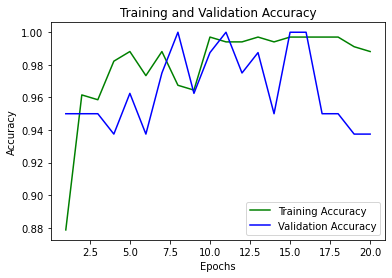

In [25]:
acc_train=model_history.history['accuracy']
acc_val=model_history.history['val_accuracy']
epochs=range(1,21)
plt.plot(epochs,acc_train,'g',label='Training Accuracy')
plt.plot(epochs,acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

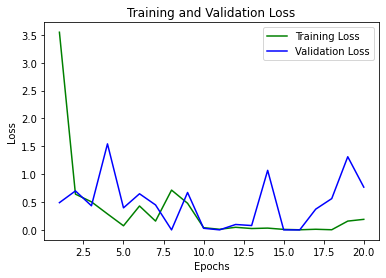

In [26]:
loss_train=model_history.history['loss']
loss_val=model_history.history['val_loss']
epochs=range(1,21)
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Making the Prediction on a Single Image

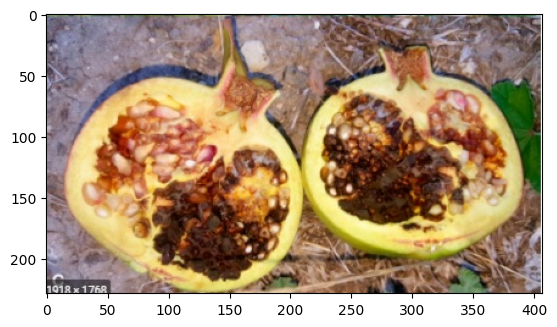

NameError: name 'model' is not defined

In [7]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define the new path for the test image
test_image_path = '/Users/shivangisingh/Desktop/pomegranate_disease_detection-main/images/train/heartrot/5.jpg'

# Load and display the test image
image_result = plt.imread(test_image_path)
plt.imshow(image_result)
plt.show()

# Preprocess the test image
test_image = image.load_img(test_image_path, target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = test_image / 255.0
test_image = np.expand_dims(test_image, axis=0)

# Predict using the model
result = model.predict(test_image)
predicted_class = np.argmax(result)

# Define categories for interpretation
categories = ['anthracnose', 'healthy', 'heartrot', 'sample']

# Display the prediction result
plt.imshow(image_result)
plt.title(categories[predicted_class])
plt.show()

print("Predicted Class:", categories[predicted_class])
